In [2]:
!pip install transformers

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
import utils.config
import random

cuda


1. Vocabulary

In [3]:
from utils.tokeniser import get_bag_of_characters, Tokenizer
from utils.config import path_chess_moves

# Fetching characters and max length from all possible chess moves
temp_vocab, MAX_LENGTH = get_bag_of_characters(path_chess_moves, return_max=True)
# Creating a voabular dictionary
vocab = {char: idx for idx, char in enumerate(temp_vocab, 1)}
# Tokeniser object
tokenizer = Tokenizer(vocab, MAX_LENGTH)
# Defining number of classes
NUM_CLASSES = len(vocab)

2. Dataset and dataloader 

In [4]:
# Identifying synthetic data 
from utils.datasets import get_image_ids, split_array
from utils.config import path_images

img_ids = get_image_ids(path_images)
random.shuffle(img_ids)
train_ids, val_ids = split_array(img_ids,ratio=0.8, debug=False)

/home/bradicic/miniconda/envs/deep_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# TRAIN/VAL data
from utils.datasets import ChessDataset, TestDataset
from utils.config import IMG_DIM, BATCH_SIZE, path_test_images, path_csv 

train_dataset = ChessDataset(path_images, IMG_DIM, train_ids, tokenizer)
validation_dataset = ChessDataset(path_images, IMG_DIM, val_ids, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# TEST dataset
test_dataset = TestDataset(path_csv, path_test_images, tokenizer, IMG_DIM)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train dataset samples (synthetic): 


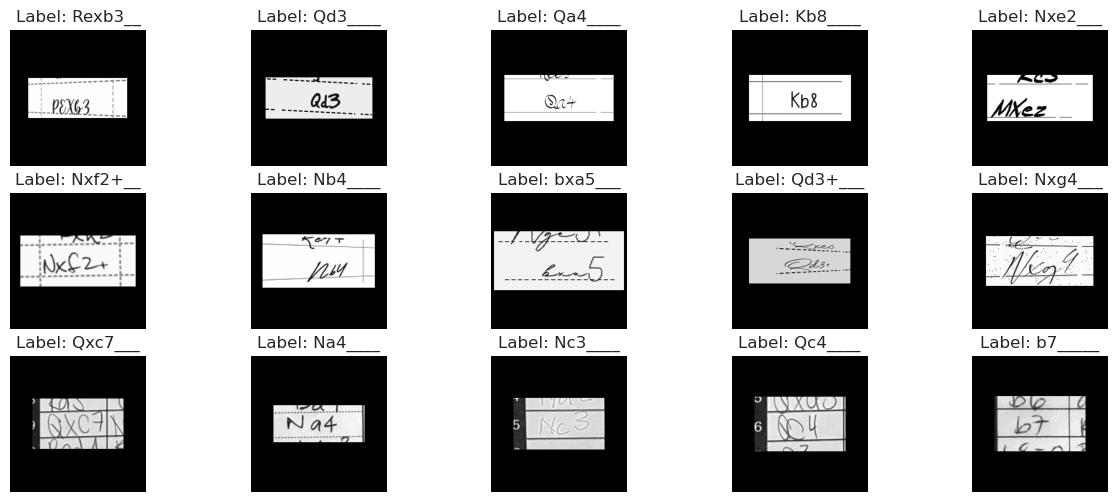

In [127]:
from utils.plotting import plot_samples

print("Train dataset samples (synthetic): ")
fig, axes = plt.subplots(3, 5, figsize=(15,6))
plot_samples(axes[0], train_dataset, tokenizer)
plot_samples(axes[1], validation_dataset, tokenizer)
plot_samples(axes[2], test_dataset, tokenizer)
plt.show()

3. Model

In [8]:
from utils.model import ViTSequenceClassifier, get_criterion
from utils.config import LR, LOSS_NAME, device, loss_hist

model = ViTSequenceClassifier(num_classes=NUM_CLASSES, max_length=MAX_LENGTH).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = get_criterion(LOSS_NAME)

4. Visualisation

In [35]:
from sklearn.metrics import confusion_matrix

model.load_state_dict(torch.load("saved/model_2024-12-18_1445__832_1.pth", weights_only=False, map_location=torch.device('cpu') ))

model.eval()
sum = 0
pred = np.array([])
true = np.array([])

for x,y in test_dataloader:
    x,y = x.to(device), y.to(device)
    y = y.cpu().numpy()
    true = np.append(true, y.flatten())

    out = model(x)
    out = torch.argmax(out, dim=2)
    out = out.cpu().numpy()
    out = [x[x != 0] for x in out]
    out = np.array([np.pad(arr, (0, 7 - len(arr)), constant_values=0) for arr in out])
    pred = np.append(pred, out.flatten())

    sum += np.sum(np.all(out == y, axis=1))

cm = confusion_matrix(true, pred)

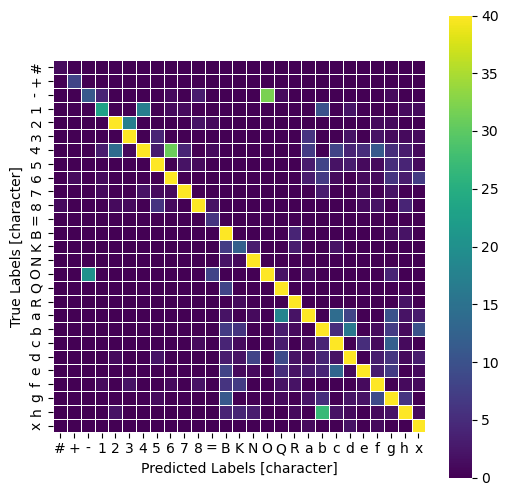

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))

# Use Seaborn to create the heatmap without annotations (no values inside blocks)
sns.heatmap(cm[1:,1:], annot=False, fmt='d', linewidths=0.5, square=True, vmax=40, cmap='viridis',
            xticklabels=[[str(k) for k, v in vocab.items()][x] for x in range(0,27)], 
            yticklabels=[[str(k) for k, v in vocab.items()][x] for x in range(0,27)],
)
# Set labels and title
# plt.title("")
plt.xlabel("Predicted Labels [character]")
plt.ylabel("True Labels [character]")

plt.show()


## Attention

In [11]:
model.load_state_dict(torch.load("saved/model_8.pth", weights_only=False, map_location=torch.device('cpu') ))

<All keys matched successfully>

In [12]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2
# from matplotlib import cm

# # Example normalization stats (ViT defaults):
# mean = np.array([0.5, 0.5, 0.5])
# std = np.array([0.5, 0.5, 0.5])

# # 1. Get a batch from the test dataloader
# x, y = next(iter(test_dataloader))  # x: (batch_size, 3, H, W)
# # Run the model
# logits, attentions = model(x)  # attentions: (num_layers, batch_size, num_heads, seq_len, seq_len)

# # Extract shapes
# num_layers = len(attentions)
# batch_size = attentions[0].shape[0]
# num_heads = attentions[0].shape[1]
# seq_len = attentions[0].shape[2]

# # Patch resolution (assuming ViT-B/16 on 224x224): seq_len = 197 = 1 [CLS] + 196 patches (14x14)
# patch_res = int((seq_len - 1) ** 0.5)  
# assert patch_res * patch_res == seq_len - 1, "Sequence length should form a square patch grid."

# # Choose which sample to visualize
# batch_idx = 0
# img_tensor = x[batch_idx].detach().cpu()  # shape: (3, H, W)
# img_np = img_tensor.permute(1,2,0).numpy()  # (H, W, 3)

# # 2. Unnormalize the image
# img_np = (img_np * std) + mean  # Unnormalize
# img_np = (img_np * 255).astype(np.uint8)  # Convert to [0,255]
# H, W, _ = img_np.shape

# # 3. Iterate over all layers and heads
# for layer_idx in range(num_layers):
#     # attentions[layer_idx] -> shape: (batch_size, num_heads, seq_len, seq_len)
#     layer_attention = attentions[layer_idx][batch_idx]  # (num_heads, seq_len, seq_len)

#     for head_idx in range(num_heads):
#         att_map = layer_attention[head_idx].detach().cpu().numpy()  # (seq_len, seq_len)
        
#         # CLS token at index 0, patches from index 1 onward
#         cls_attention = att_map[0, 1:]  # shape: (196,)
        
#         # Reshape to patch grid
#         cls_attention_2d = cls_attention.reshape(patch_res, patch_res)

#         # Normalize attention to [0,1]
#         cls_attention_2d = (cls_attention_2d - cls_attention_2d.min()) / (cls_attention_2d.max() - cls_attention_2d.min())

#         # Resize attention map to image size
#         att_map_resized = cv2.resize(cls_attention_2d, (W, H), interpolation=cv2.INTER_CUBIC)

#         # Create a heatmap from attention map
#         cmap = cm.get_cmap('jet')
#         heatmap = cmap(att_map_resized)[:, :, :3]  # RGBA -> RGB

#         # Blend heatmap with original image
#         alpha = 0.5
#         overlay = (heatmap * 255 * alpha + img_np * (1 - alpha)).astype(np.uint8)

#         # Plot original and overlay
#         fig, axes = plt.subplots(1, 2, figsize=(12, 6))
#         axes[0].imshow(img_np)
#         axes[0].set_title("Original Image")
#         axes[0].axis('off')

#         axes[1].imshow(overlay)
#         axes[1].set_title(f"Attention Overlay (Layer {layer_idx}, Head {head_idx})")
#         axes[1].axis('off')

#         plt.tight_layout()
#         plt.show()


In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib import cm

# Example normalization stats (ViT defaults):

# 1. Get a batch from the test dataloader

# Extract shapes
num_layers = len(attentions)
batch_size = attentions[0].shape[0]
num_heads = attentions[0].shape[1]
seq_len = attentions[0].shape[2]

# Patch resolution (assuming ViT-B/16 on 224x224): seq_len = 197 = 1 [CLS] + 196 patches (14x14)
patch_res = int((seq_len - 1) ** 0.5)  
assert patch_res * patch_res == seq_len - 1, "Sequence length should form a square patch grid."

# Choose which sample to visualize

batch_idx = 0
img_tensor = x[batch_idx].detach().cpu()  # shape: (3, H, W)
img_np = img_tensor.permute(1,2,0).numpy()  # (H, W, 3)

# 2. Unnormalize the image
img_np = (img_np * std) + mean  # Unnormalize
img_np = (img_np * 255).astype(np.uint8)  # Convert to [0,255]
H, W, _ = img_np.shape



NameError: name 'attentions' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_6739/3745906978.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')


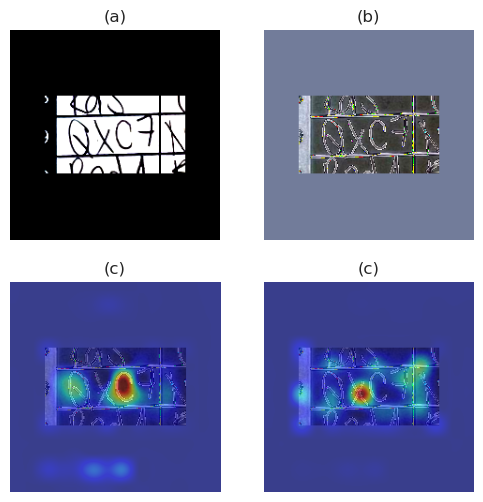

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

axes[0][0].imshow(x[0].permute(1,2,0))
axes[0][0].set_title("(a)")
axes[0][0].axis('off')


axes[0][1].imshow(img_np)
axes[0][1].set_title("(b)")
axes[0][1].axis('off')

axes[1][0].imshow(make_overlayer(img_np, 5,9))
axes[1][0].set_title(f"(c)")
axes[1][0].axis('off')

axes[1][1].imshow(make_overlayer(img_np, 5,7))
axes[1][1].set_title(f"(c)")
axes[1][1].axis('off')

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_6739/3745906978.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


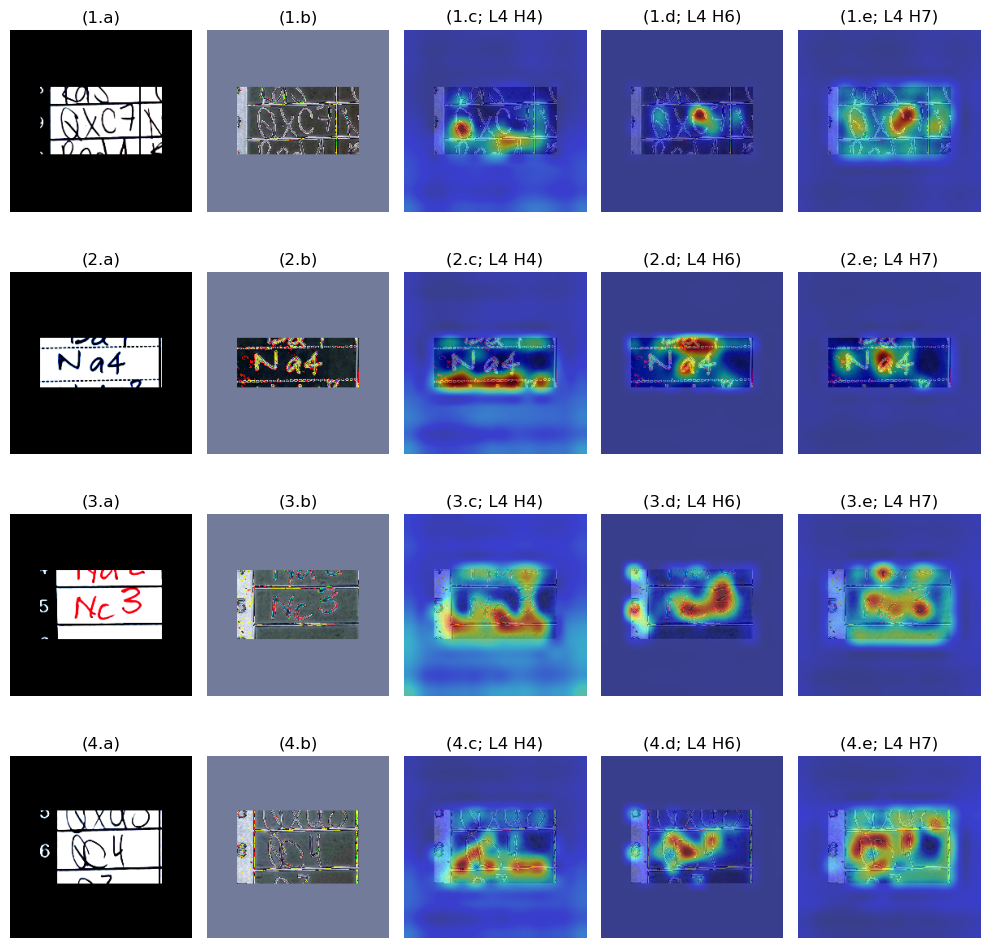

In [ ]:
def make_overlayer(img_np, layer_idx, head_idx):
    layer_attention = attentions[layer_idx][batch_idx]  # (num_heads, seq_len, seq_len)

    att_map = layer_attention[head_idx].detach().cpu().numpy()  # (seq_len, seq_len)

    # CLS token at index 0, patches from index 1 onward
    cls_attention = att_map[0, 1:]  # shape: (196,)

    # Reshape to patch grid
    cls_attention_2d = cls_attention.reshape(patch_res, patch_res)

    # Normalize attention to [0,1]
    cls_attention_2d = (cls_attention_2d - cls_attention_2d.min()) / (cls_attention_2d.max() - cls_attention_2d.min())

    # Resize attention map to image size
    att_map_resized = cv2.resize(cls_attention_2d, (W, H), interpolation=cv2.INTER_CUBIC)

    # Create a heatmap from attention map
    cmap = cm.get_cmap('jet')
    heatmap = cmap(att_map_resized)[:, :, :3]  # RGBA -> RGB

    # Blend heatmap with original image
    alpha = 0.5
    overlay = (heatmap * 255 * alpha + img_np * (1 - alpha)).astype(np.uint8)

    return overlay


dim = (4, 5)
fig, axes = plt.subplots(dim[0], dim[1], figsize=(10,10))

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

x, y = next(iter(test_dataloader))  # x: (batch_size, 3, H, W)
# Run the model
logits, attentions = model(x)  # attentions: (num_layers, batch_size, num_heads, seq_len, seq_len)

num_layers = len(attentions)
batch_size = attentions[0].shape[0]
num_heads = attentions[0].shape[1]
seq_len = attentions[0].shape[2]

# Patch resolution (assuming ViT-B/16 on 224x224): seq_len = 197 = 1 [CLS] + 196 patches (14x14)
patch_res = int((seq_len - 1) ** 0.5)  
assert patch_res * patch_res == seq_len - 1, "Sequence length should form a square patch grid."


for i in range(0,dim[0]):
    batch_idx = i
    img_tensor = x[batch_idx].detach().cpu()  # shape: (3, H, W)
    img_np = img_tensor.permute(1,2,0).numpy()  # (H, W, 3)

    # 2. Unnormalize the image
    img_np = (img_np * std) + mean  # Unnormalize
    img_np = (img_np * 255).astype(np.uint8)  # Convert to [0,255]
    H, W, _ = img_np.shape


    for j in range(0,dim[1]):
        if j == 0:
            axes[i][j].imshow(x[i].permute(1,2,0))
            axes[i][j].set_title(f"({i+1}.a)")
            axes[i][j].axis('off')
        if j == 1:
            axes[i][j].imshow(img_np)
            axes[i][j].set_title(f"({i+1}.b)")
            axes[i][j].axis('off')
        if j == 2:
            axes[i][j].imshow(make_overlayer(img_np, 4, 4))
            axes[i][j].set_title(f"({i+1}.c; L4 H4)")
            axes[i][j].axis('off')
        if j == 3:
            axes[i][j].imshow(make_overlayer(img_np, 4, 6))
            axes[i][j].set_title(f"({i+1}.d; L4 H6)")
            axes[i][j].axis('off')
        if j == 4:
            axes[i][j].imshow(make_overlayer(img_np, 4, 7))
            axes[i][j].set_title(f"({i+1}.e; L4 H7)")
            axes[i][j].axis('off')



plt.tight_layout()
plt.show()


In [ ]:
# Model plots

'lr: 6*10-5'

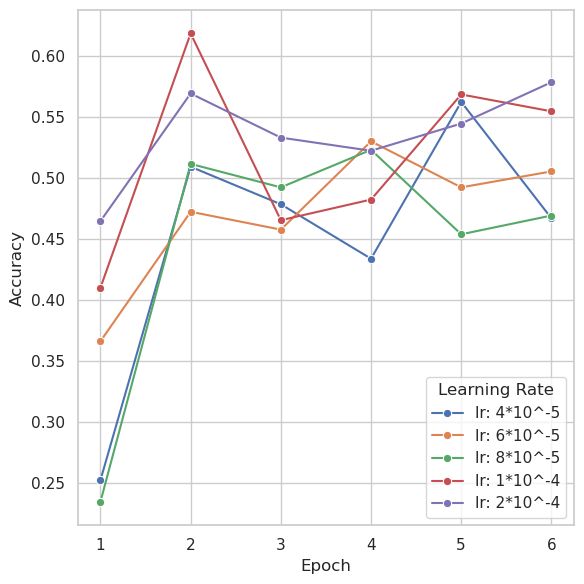

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice theme
sns.set_theme(style="whitegrid")

model = {
    1: [328, 662, 622, 564, 731, 607],
    2: [476, 614, 595, 689, 640, 657],
    3: [305, 665, 640, 680, 590, 610],
    4: [533, 804, 605, 627, 739, 721],
    5: [604, 740, 693, 679, 708, 752],
}
learning_rate = {
    1: "lr: 4*10^-5",
    2: "lr: 6*10^-5",
    3: "lr: 8*10^-5",
    4: "lr: 1*10^-4",
    5: "lr: 2*10^-4",
}


fig, ax = plt.subplots(figsize=(6,6))

# Label axes
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

for key, values in model.items():
    # Normalize by dividing by 1300
    accuracies = [x / 1300 for x in values]
    # Use epoch numbers starting from 1
    epochs = range(1, len(accuracies) + 1)
    
    # Use Seaborn lineplot wmatrix.shapeith markers and a legend
    sns.lineplot(x=epochs, y=accuracies, marker='o', label=f"{learning_rate[key]}", ax=ax)

# Add a title and show the legend
ax.legend(title="Learning Rate")

plt.tight_layout()
plt.show()


In [91]:
file = open("../preds_and_labels_padded.csv")
 
#  pred_
#label prediction

pred_ = np.array([])
true_ = np.array([])
for idx, sequence in enumerate(file):
    if idx == 0:
        continue
    a,b = sequence.split(',')
    a_ = [char if char != '.' else '_' for char in a.replace("\n", "")]
    b_ = [char if char != '.' else '_' for char in b.replace("\n", "")]
    pred_ = np.append(pred_, b_)
    true_ = np.append(true_, a_)


In [93]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, classification_report

# Example flattened arrays
# Replace these with your actual predictions and true labels
y_true = true_
y_pred = pred_

# Get the list of unique classes
classes = np.unique(np.concatenate((y_true, y_pred)))

# Compute precision and recall for each class
precision = precision_score(y_true, y_pred, labels=classes, average=None)
recall = recall_score(y_true, y_pred, labels=classes, average=None)

# Display the results
for cls, p, r in zip(classes, precision, recall):
    print(f"Class {cls}: Precision = {p:.2f}, Recall = {r:.2f}")

# Alternatively, use classification_report for a comprehensive summary
print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=classes))



Class #: Precision = 1.00, Recall = 0.50
Class +: Precision = 0.75, Recall = 0.90
Class -: Precision = 0.93, Recall = 0.94
Class 1: Precision = 0.97, Recall = 0.64
Class 2: Precision = 0.91, Recall = 0.73
Class 3: Precision = 0.90, Recall = 0.98
Class 4: Precision = 0.93, Recall = 0.93
Class 5: Precision = 0.89, Recall = 0.91
Class 6: Precision = 0.87, Recall = 0.91
Class 7: Precision = 0.87, Recall = 0.98
Class 8: Precision = 0.94, Recall = 0.80
Class =: Precision = 1.00, Recall = 1.00
Class B: Precision = 0.84, Recall = 0.98
Class K: Precision = 0.88, Recall = 0.56
Class N: Precision = 0.99, Recall = 0.97
Class O: Precision = 0.93, Recall = 0.94
Class Q: Precision = 0.91, Recall = 0.97
Class R: Precision = 0.89, Recall = 0.84
Class _: Precision = 0.99, Recall = 0.99
Class a: Precision = 0.96, Recall = 0.69
Class b: Precision = 0.86, Recall = 0.97
Class c: Precision = 0.76, Recall = 0.89
Class d: Precision = 0.95, Recall = 0.84
Class e: Precision = 0.87, Recall = 0.70
Class f: Precisi

In [55]:
def levenshteinRecursive(pred, target, m, n):
      # pred is empty
    if m == 0:
        return n
    # str2 is empty
    if n == 0:
        return m
    if pred[m - 1] == target[n - 1]:
        return levenshteinRecursive(pred, target, m - 1, n - 1)
    return 1 + min(
          # Insert     
        levenshteinRecursive(pred, target, m, n - 1),
        min(
            levenshteinRecursive(pred, target, m - 1, n),
            levenshteinRecursive(pred, target, m - 1, n - 1))
    )

def evaluate_model(model, dataloader, criterion, BATCH_SIZE, device, loss_name):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for pixel_values, labels in dataloader:
            pixel_values, labels = pixel_values.to(device), labels.to(device)
            logits = model(pixel_values)

            loss = 0
            if loss_name == "CTC":
                loss = compute_loss_CTC(logits, labels, criterion)
            elif loss_name == "cross_entropy":
                for i in range(model.max_length):
                    loss += criterion(logits[:, i, :], labels[:, i])
            
            total_loss += loss
    return total_loss/(len(dataloader) * BATCH_SIZE)

array(['              precision    recall  f1-score   support', '',
       '         0.0       1.00      0.96      0.98      5465',
       '         1.0       0.50      0.50      0.50         2',
       '         2.0       0.19      0.80      0.31        10',
       '         3.0       0.34      0.21      0.26        53',
       '         4.0       0.55      0.41      0.47        56',
       '         5.0       0.70      0.68      0.69        79',
       '         6.0       0.83      0.90      0.87       190',
       '         7.0       0.82      0.70      0.75       332',
       '         8.0       0.76      0.85      0.80       221',
       '         9.0       0.73      0.86      0.79       214',
       '        10.0       0.88      0.90      0.89       112',
       '        11.0       0.83      0.78      0.81        93',
       '        12.0       0.27      1.00      0.43         6',
       '        13.0       0.72      0.96      0.82       173',
       '        14.0       0.34     

In [96]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize the output
n_classes = len(vocab)
y_test_binarized = label_binarize(y_true, classes=range(n_classes))
y_pred_vit_proba = vit_model.predict_proba(X_test)
y_pred_bilstm_proba = bilstm_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr_vit = dict()
tpr_vit = dict()
roc_auc_vit = dict()
fpr_bilstm = dict()
tpr_bilstm = dict()
roc_auc_bilstm = dict()

for i in range(n_classes):
    fpr_vit[i], tpr_vit[i], _ = roc_curve(y_test_binarized[:, i], y_pred_vit_proba[:, i])
    roc_auc_vit[i] = auc(fpr_vit[i], tpr_vit[i])
    fpr_bilstm[i], tpr_bilstm[i], _ = roc_curve(y_test_binarized[:, i], y_pred_bilstm_proba[:, i])
    roc_auc_bilstm[i] = auc(fpr_bilstm[i], tpr_bilstm[i])

# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow', 'lime', 'teal', 'navy', 'maroon', 'gold', 'silver', 'tan', 'orchid', 'salmon', 'khaki', 'lavender', 'beige', 'coral', 'plum'])

plt.figure(figsize=(20, 10))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_vit[i], tpr_vit[i], color=color, lw=2,
             label='ViT ROC curve for class {0} (area = {1:0.2f})'
                   ''.format(classes[i], roc_auc_vit[i]))
    plt.plot(fpr_bilstm[i], tpr_bilstm[i], linestyle='--', color=color, lw=2,
             label='BiLSTM ROC curve for class {0} (area = {1:0.2f})'
                   ''.format(classes[i], roc_auc_bilstm[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves for ViT and BiLSTM Models')
plt.legend(loc="lower right", fontsize='small')
plt.show()


NameError: name 'vit_model' is not defined

CTC/CER plot

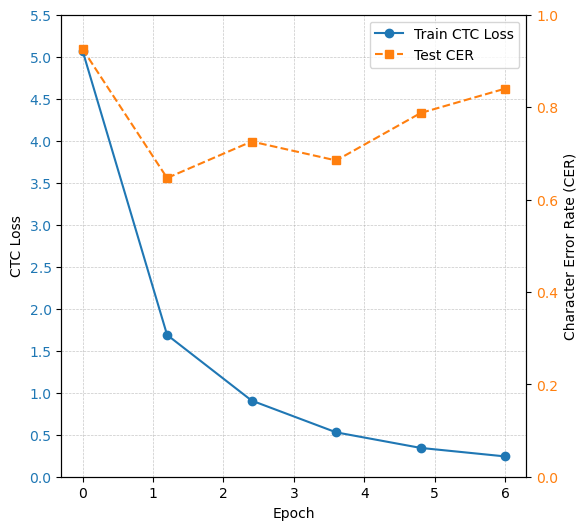

In [41]:
np.linspace(0,100,5)

array([  0.,  25.,  50.,  75., 100.])

In [66]:
def plot_loss_train_cer_test(ax1, test_loss, cer):

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("CTC Loss")
    line1, = ax1.plot(np.linspace(0, len(test_loss), len(test_loss)), test_loss, label="Train CTC Loss", color='C0', marker='o')
    ax1.yaxis.set_major_locator(mticker.MultipleLocator(0.5))
    ax1.tick_params(axis='y', labelcolor='C0')
    ax1.set_ylim(0,5.5)

    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)


    ax2 = ax1.twinx()
    ax2.set_ylabel("Character Error Rate (CER)")
    line2, = ax2.plot(np.linspace(0, len(cer), len(cer)), cer, label="Test CER", color="C1", ls='--', marker='s')
    ax2.set_ylim(0.5,1)
    ax2.tick_params(axis='y', labelcolor='C1')


    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper right')

    plt.show()


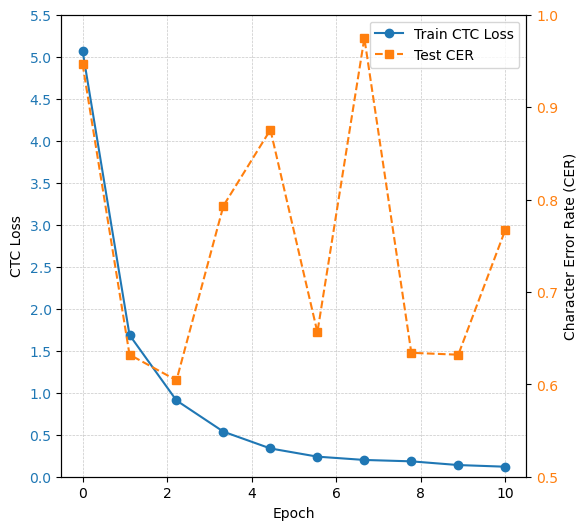

In [67]:

import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker  # Import the ticker module
from utils.model import read_logs
import ast
import numpy as np

# path = "logs/output_2024-12-18_2238.csv"

# dict = read_logs(path)
# dict['test_cer'] = np.array(ast.literal_eval(dict['test_cer']), dtype=float)

train_loss = np.array([5.071956162166596, 1.687561345434189, 0.9077995473146439, 0.5360365901589393, 0.33646111479401586, 0.2389075836956501, 0.19963398912250996, 0.18309580106586218, 0.13899942983090877, 0.11917196599543095])
test_cer = np.array([0.9467041446208113, 0.6321373456790124, 0.6043320105820106, 0.7932649911816577, 0.8754684744268078, 0.656360229276896, 0.9747023809523809, 0.6340939153439153, 0.6320546737213404, 0.7670855379188714])
fig, ax1 = plt.subplots(1,1, figsize=(6,6))
plot_loss_train_cer_test(ax1, train_loss, test_cer)


In [52]:
def plot_loss_train_cer_test(ax1, test_loss, cer):

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("CTC Loss")
    line1, = ax1.plot(np.linspace(0, 100, 20), test_loss, label="Train CTC Loss", color='C0', marker='o')
    ax1.yaxis.set_major_locator(mticker.MultipleLocator(0.5))
    ax1.tick_params(axis='y', labelcolor='C0')
    ax1.set_ylim(0,3)

    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)


    ax2 = ax1.twinx()
    ax2.set_ylabel("Character Error Rate (CER)")
    line2, = ax2.plot(np.linspace(0, 100, 20), cer, label="Test CER", color="C1", ls='--', marker='s')
    ax2.set_ylim(0,0.8)
    ax2.tick_params(axis='y', labelcolor='C1')


    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper right')

    plt.show()


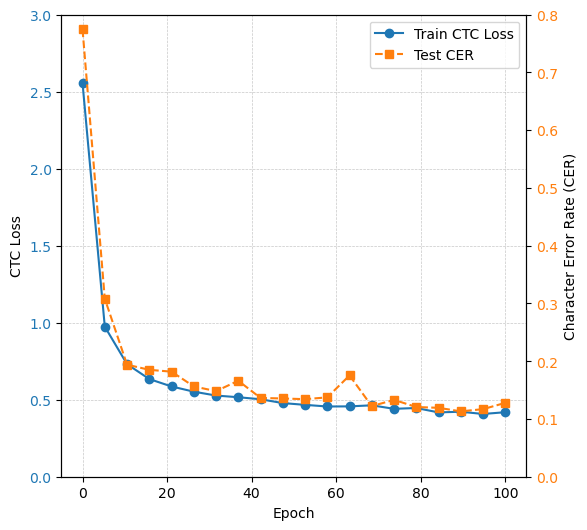

In [53]:
import csv 
path = "bilstm_val_cer.csv"

full_cer = np.array([])
with open(path, mode="r") as file:
    reader = csv.reader(file)
    for i, row in enumerate(reader):
        if i == 0:
            continue
        full_cer = np.append(full_cer, row[1])

import csv 
path = "bilstm_train_loss.csv"

full_ctc_loss = np.array([])
with open(path, mode="r") as file:
    reader = csv.reader(file)
    for i, row in enumerate(reader):
        if i == 0:
            continue
        full_ctc_loss = np.append(full_ctc_loss, row[1])

fig, ax1 = plt.subplots(1,1, figsize=(6,6))
plot_loss_train_cer_test(ax1, full_ctc_loss[::5].astype(float), full_cer[::5].astype(float))
